# EDA 
Marc Letourneur, on Feb 6th, 2018.

## A Million News Headlines
https://www.kaggle.com/therohk/million-headlines

The dataset contains the headlines published by the Australian news agency ABC from 2003-02-19 to 2017-12-31.

### Data format 
column 1 > date of publication, format yyyyMMdd

column 2 > headline, format ascii string, lowercase

### General comments
In this preliminary work, the objective is to derive some questions that we could ask the data.

Here we have a dataset with a specific dimension: time.
As suggested in the description of the dataset (ABOUT.md in /data from Kaggle) the news are somehow a proxy to get to know history, real facts and trends. We expect the data to reveal/show some historical milestones, some social trends...

There is bias involved in reporting the facts to the public > the news is filtering reality because of some subjectivity, interpretation, biased information source, unknown facts etc.

Some bias sources: 
- journalists point of view might be Australia-centered? pro Australia (patriotism)? > subjectivity

- political bias of the editor/journalists (right-wing, left-wing, pro-life, nationalism) > subjectivity

- the subjectivity of the reader. The reader brings some bias as he/she is interpreting the headline. Moreover, news headlines are often ambiguous by construction, either on purpose (catchy headlines), either because of the length constraint on newspapers. 

- the reality of daily journalism: no access to pure facts, but usually via proxies, people testimony, witnesses, social media filters, scarce data etc.

We are going to simply call the first subjectivity source the "Australian point of view". This special point of view may tackle the international news with a different angle compared to other agencies from other countries.
This could be an angle for us: between this dataset and another one, do a relative comparison of what is reported - sentiment about facts? Importance of some topics? Focus on milestones?... 

In our problem, we have no ground truth, no target variable. Just raw data.
So we may want to identify the patterns that exist in the dataset and compare them to the patterns we may find in other - also subjective/biased datasets - in an unsupervised scheme.
This would help us unveil some aspects of this subjectivity/filter/bias that could be specific to ABC.

The dimension of time may also allow us to unveil some trends, topics, social concerns, hot topics across periods.


## Discovery and sanity check

### Load the dataset

In [1]:
import pandas as pd
df = pd.read_csv('./data/abcnews-date-text.csv')
df.head(5)

publish_date                                      headline_text
0      20030219  aba decides against community broadcasting lic...
1      20030219     act fire witnesses must be aware of defamation
2      20030219     a g calls for infrastructure protection summit
3      20030219           air nz staff in aust strike for pay rise
4      20030219      air nz strike to affect australian travellers

In [2]:
df.count()

publish_date     1103665
headline_text    1103665
dtype: int64

#### We have 1 103 665 headlines in total as expected

In [3]:
df.headline_text[0].split(' ')

['aba', 'decides', 'against', 'community', 'broadcasting', 'licence']

Let's convert the headlines strings into word list to count words per headline

In [4]:
df['headline_words'] = df.headline_text.apply(lambda x: x.split(' '))

In [5]:
df.dtypes

publish_date       int64
headline_text     object
headline_words    object
dtype: object

In [6]:
# Get the number of words per headline
df['nb_words'] = df.headline_words.apply(lambda x: len(x))
nb_w = df.groupby('nb_words').count()['headline_words']

In [7]:
# Load visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

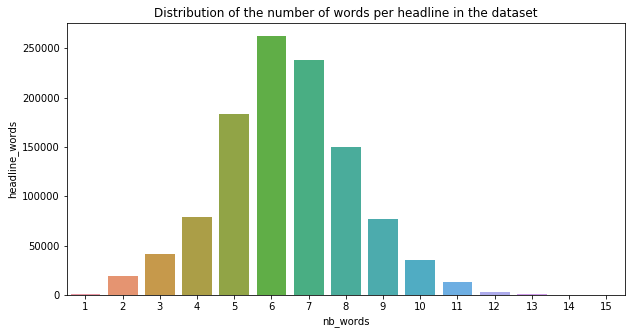

In [8]:
plt.figure(figsize=(10,5))
sns.barplot(nb_w.index, nb_w)
t = plt.title('Distribution of the number of words per headline in the dataset')

In [9]:
df.nb_words.describe()

count    1.103665e+06
mean     6.406342e+00
std      1.806131e+00
min      1.000000e+00
25%      5.000000e+00
50%      6.000000e+00
75%      8.000000e+00
max      1.500000e+01
Name: nb_words, dtype: float64

#### The mean number of words per headline over the full dataset is 6.4  words.
A headline is no more than 15 words.

As we could expect, headlines are on average really short which may favor ambiguity and misinterpretation.


Let's look at the publication dates 

In [10]:
#Converting dates to datetime format easier to handle
df.publish_date =  pd.to_datetime(df.publish_date.apply(lambda x: str(x)), format='%Y%m%d')

In [11]:
df.head(2)

publish_date                                      headline_text  \
0   2003-02-19  aba decides against community broadcasting lic...   
1   2003-02-19     act fire witnesses must be aware of defamation   

                                      headline_words  nb_words  
0  [aba, decides, against, community, broadcastin...         6  
1  [act, fire, witnesses, must, be, aware, of, de...         8

In [12]:
df.publish_date.min(), df.publish_date.max()

(Timestamp('2003-02-19 00:00:00'), Timestamp('2017-12-31 00:00:00'))

#### As the documentation detailed, it starts from '2003-02-19' and end '2017-12-31'

Let's see how the data is balanced per period of interest (year, month, day...). How many headlines per year?

In [13]:
df['year'] = df.publish_date.apply(lambda x: x.year)
df['month'] = df.publish_date.apply(lambda x: x.month)
df['day'] = df.publish_date.apply(lambda x: x.day)

In [14]:
# Yearly number of headlines
gnb_year = df.groupby(['year']).count()['headline_text']

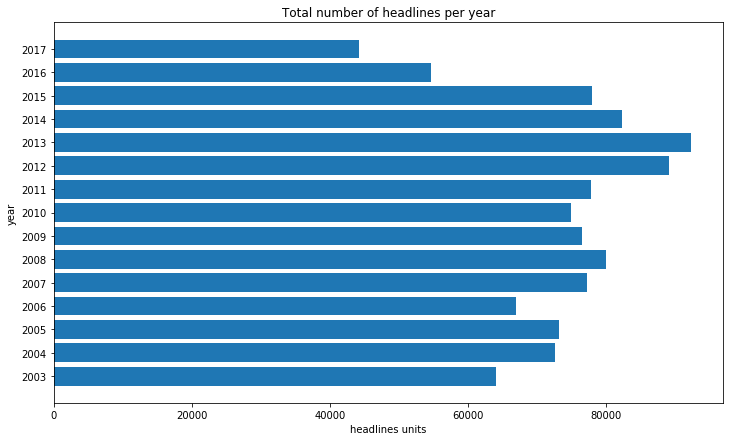

In [15]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.barh(gnb_year.index, gnb_year)
ax.set_yticks(gnb_year.index)
plt.title('Total number of headlines per year')
plt.xlabel('headlines units')
t = plt.ylabel('year')

There is quite a huge difference in the yearly total of headlines, for instance, between 2017 and 2013.
The difference represents roughly 131 headlines per day, during a year.

In [16]:
(gnb_year.loc[2013]-gnb_year.loc[2017]) # delta = 48155 headlines!
# Addititional headlines published per day in 2013 (compared to 2017)
(gnb_year.loc[2013]-gnb_year.loc[2017])/365.35

131.80511837963596

2017 contains the least number of headlines while 2013 & 2012 have the most headlines over the dataset.
So we could instead compare 2017 to the mean yearly nb of headlines to get closer to the steady state publication rate.

In [17]:
(gnb_year.mean()-gnb_year.loc[2017])/365.35

80.45892066967748

In [18]:
gnb_year.loc[2017]/365.35

120.93061447926645

Still, around 66% difference in daily publication rates between 2017 and the other years.

From this point, it is hard to give an explanation for such huge differences.
ABC was able to increase significantly the number of headlines until 2013 when it started to drop.

Also, we don't know if some headlines were in fact published but were not reported in the dataset.

Let us check if there are some holes in the time frame.

In [19]:
# Get the number of effective days per year reported in the db
l = df[['year', 'month', 'day']]
l = l.drop_duplicates()
l.groupby(['year']).count()['day']

year
2003    316
2004    364
2005    364
2006    363
2007    363
2008    365
2009    365
2010    365
2011    365
2012    366
2013    365
2014    365
2015    365
2016    366
2017    365
Name: day, dtype: int64

It seems that only really few dates are missing. This is not significant.
We can check whether there is still some days with few headlines reported

In [20]:
# Function to ease sorting the month/day index: padding with 0 
def pad_str(s):
    if len(s) == 1:
        return '0'+ s
    else:
        return s

df['year_month_day']= df.publish_date.apply(lambda x: str(x.year) + ' ' + pad_str(str(x.month)) + ' ' + pad_str(str(x.day)))
gnb_year_month_day = df.groupby(['year_month_day']).count()['headline_text']
gnb_year_month_day.sort_index(inplace=True)

# List of dates with limited amount of publications with the threshold at 50 headlines a day
gnb_year_month_day[gnb_year_month_day < 50]

year_month_day
2006 09 02    19
2006 09 03    24
2006 09 04    25
2006 09 05    23
2006 09 06    24
2006 09 07    25
2006 09 08    23
2006 09 09    25
2006 09 10    24
2006 09 11    24
2006 09 12    24
2006 09 13    24
2006 09 28    24
2006 09 29    23
2006 09 30    25
2006 10 01    22
2006 10 02    25
2006 10 03    25
2006 10 04    23
2006 10 05    25
2006 10 06    23
2006 10 07    23
2006 10 08    23
2006 10 09    25
2006 10 24    24
2006 10 25    23
2006 10 26    24
2006 10 27    22
2006 10 28    21
2006 10 29    23
2006 10 30    25
2006 11 01    24
2006 11 02    24
2006 11 03    23
2006 11 04    21
2006 11 05    21
2011 12 25    36
2013 12 25    38
2014 12 25    38
2015 01 06    21
2015 01 07    26
2015 01 08    23
2015 01 09    21
2015 01 10    19
2015 01 11    19
2015 01 12    25
2015 01 17    18
2015 01 18    19
2016 12 25    49
2017 04 16    48
2017 12 25    24
Name: headline_text, dtype: int64

September, October and November 2006 are, roughly, the only ones getting low (<50) nb of headlines.

#### Sanity check:
It seems that we are not missing significant dates in the time frame. And for each day of the frame, at least 50 headlines have been reported (roughly), and on average 201.

## Major topics

Let's start unveiling the key topics.

We can start analyzing the keywords frequency per time frame.
We can build a vocabulary of monograms, bigrams, and n-grams...

Trying to run the following operations on the whole set has caused the kernel to die.
So we are working on a sample of the dataframe to enable calculation of vocabulary.

In [22]:
df_samp = df.sample(frac=0.10, random_state=23) # retaining 10%, seed set for reproducibility

In [117]:
# Build the vocabulary with bag of words
from sklearn.feature_extraction.text import CountVectorizer
# We don't provide the size of the vocabulary
vectorizer = CountVectorizer() # Modifying ngram_range to ngram_range=(1,3) causes KERNEL TO DIE
bow = vectorizer.fit_transform(df_samp.headline_text)
bow = bow.toarray()

In [118]:
bow.shape

(110366, 38610)

In [120]:
# We get 38610 features. Let's have a look at the Vocabulary
vocab = vectorizer.get_feature_names()

In [121]:
#KERNEL DYING FOR THE ENTIRE DATASET#
import numpy as np
# Array of token frequencies
freqs = np.sum(bow, axis=0)

In [122]:
voca = pd.DataFrame({"voca_words" :vocab, "freq": freqs})
# Number of tokens in the sample
nb_total_words = np.sum(freqs)
# Adding frequency as a percentage
voca['freq_percent'] = voca.freq.apply(lambda x: x*100.0/nb_total_words)

In [123]:
voca.loc[np.argsort(freqs)].sort_values(['freq'], ascending=False).head(5)

freq voca_words  freq_percent
34823  21304         to      3.032196
17606  13663         in      1.944654
13895  12806        for      1.822677
24495   8016         of      1.140917
24640   7405         on      1.053953

We can filter out the stop words. Using the built-in list in sklearn.
Let's re-compute the vocabulary.

In [125]:
vectorizer = CountVectorizer(stop_words='english') # Modifying ngram_range to ngram_range=(1,3) causes KERNEL TO DIE
bow = vectorizer.fit_transform(df_samp.headline_text)
bow = bow.toarray()

In [126]:
vocab = vectorizer.get_feature_names()

In [132]:
stop_words = vectorizer.get_stop_words()
len(stop_words) # 318 stop words in this built-in list

In [127]:
# Array of token frequencies
freqs = np.sum(bow, axis=0)

In [129]:
voca = pd.DataFrame({"voca_words" :vocab, "freq": freqs})
# Number of tokens in the sample
nb_total_words = np.sum(freqs)
# Adding frequency as a percentage
voca['freq_percent'] = voca.freq.apply(lambda x: x*100.0/nb_total_words)

In [131]:
voca.loc[np.argsort(freqs)].sort_values(['freq'], ascending=False).head(20)

freq  voca_words  freq_percent
26348  3654      police      0.649761
23727  2925         new      0.520129
21253  2703         man      0.480652
30147  2040        says      0.362756
8992   1646       court      0.292695
8944   1611     council      0.286471
15143  1603        govt      0.285048
17972  1507   interview      0.267977
24103  1300         nsw      0.231168
26123  1260        plan      0.224055
27391  1215         qld      0.216053
3426   1201   australia      0.213564
37010  1157       water      0.205740
9103   1145       crash      0.203606
36709  1106          wa      0.196671
9834   1102       death      0.195960
33592  1095      sydney      0.194715
16212  1054      health      0.187424
3427   1039  australian      0.184757
7195    986     charged      0.175332

 We can try to add bigrams in the vocab to take into account location/country/entity names.

In [ ]:
vectorizer_bi = CountVectorizer(stop_words='english', ngram_range=(1,2)) # Modifying ngram_range=(1,2) to get bigrams
bow_bi= vectorizer_bi.fit_transform(df_samp.headline_text)
bow_bi = bow_bi.toarray()

> The Major Topics goes on another notebook. 